# Persistent Homology (dim=0)

```
input: image I with shape (H,W)
output: dgm array with birth and death values

1. M = arg-maxpool2d(I)
2. pbirth = unique(M), M = reindex(M)
3. B = maxpool(M) != -maxpool(-M)
4. B = distillation(B)
5. B = sort(B)
   For x in B:
     if x is border of 2 partitions P:
        x is added in pdeath
        C[x] = min(P)
6. dgm = (I[pbirth], I[pdeath])
```

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import maxpool2d, neighbors, my_saddle

In [2]:
img = fits.getdata("")

img = img[0:20,0:20].astype(np.float32)

img -= img.min()
img /= img.max()

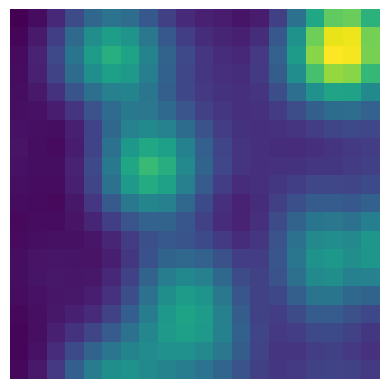

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

## 1. Identification of the concave components

The initial step involves identifying the concave elements within the image $I$. To accomplish this, we compute, for each pixel, the index of the pixel with the highest value among its eight neighboring pixels, using the $arg-maxpool2d(x)$ operation. The generated index array is recursively processed until a labeled image $M$ is achieved.


In [4]:
H, W = img.shape
p, m = maxpool2d(img, kernel_size=3, stride=1, padding=1, return_indices=True)
del p

img = img.flatten()
m_temp = m.flatten()
m = m_temp[m_temp]
while not np.array_equal(m_temp, m):
    m_temp = m
    m = m_temp[m_temp]
del m_temp

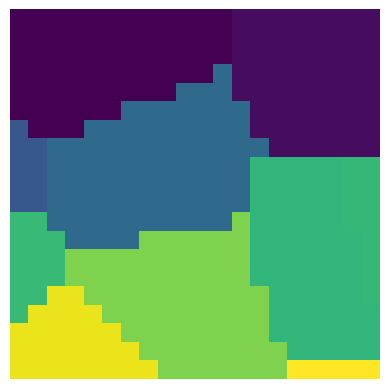

In [5]:
plt.imshow(m.reshape(H,W))
plt.axis('off')
plt.show()

## 2. Locate birth points (Re-Indexing of components)
Currently, the detected elements are labeled with the index of their neighbor relative maximum. We gather all the indices of relative maxima into an array $pbirth$. Before moving on, we assign sequential numbers to the zones, starting from the one with the smallest relative maximum to the one with the largest one.

In [6]:
pbirth = np.unique(m)
birth = img[pbirth]
idxs = np.argsort(birth)
pbirth = pbirth[idxs]

In [7]:
dict_replace = {pbirth[i]: i+1 for i in range(birth.size)}
p_idxs = np.sort(idxs + 1)

def replace(element):
    return dict_replace.get(element, element)
vreplace = np.vectorize(replace)
new_m = vreplace(m)

del birth, idxs, dict_replace, vreplace

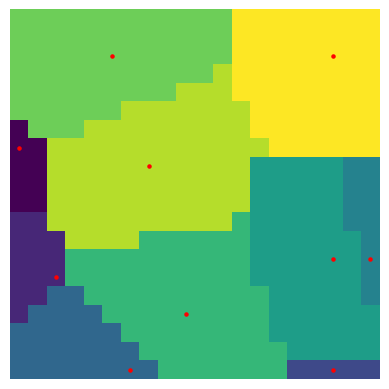

In [8]:
plt.imshow(new_m.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.axis('off')
plt.show()

## 3. Find the edges

After have partitioned the image into distinct components, we detect the edges, and within the found edges we later locate the dead points $pdeath$.

To detect the edges, we calculate the $maxpool2d$ of $M$ and $-M$. The area of our interest will be the region $B$ where these two arrays differ.


In [9]:
p1 = maxpool2d(new_m.reshape(H, W), kernel_size=3, stride=1, padding=1, return_indices=False).flatten()
p2 = -maxpool2d(-new_m.reshape(H, W), kernel_size=3, stride=1, padding=1, return_indices=False).flatten()

borders_idxs = set(np.nonzero(p1 != p2)[0].tolist())

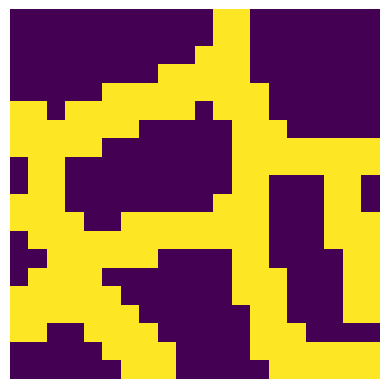

In [10]:
mask = np.zeros((H,W)).flatten()
mask[list(borders_idxs)] = 1
mask = mask.reshape(H,W)

plt.imshow(mask)
plt.axis('off')
plt.show()

## 4. Distillation
By definition, dead points are located along border regions. Moreover, to connect two adjacent areas, they must be either relative minimum points or saddle points. Any point failing to meet these criteria is subsequently removed from the previous array $B$.

In [11]:
img_pad = np.pad(img.reshape(H,W), ((1, 1), (1, 1)), 'constant', constant_values=0)
for x in borders_idxs.copy():
    w = x // W
    h = x % W
    if not my_saddle(img_pad[w:(w+3), h:(h+3)]):
        borders_idxs.discard(x)
for x in np.flip(pbirth):
    for y in neighbors(x, H, W):
        if new_m[y] != new_m[x]:
            borders_idxs.add(y)
    borders_idxs.discard(x)
del img_pad

borders_idxs = np.array(list(borders_idxs))
sort = np.flip(np.argsort(img[borders_idxs]))
borders_idxs = borders_idxs[sort]

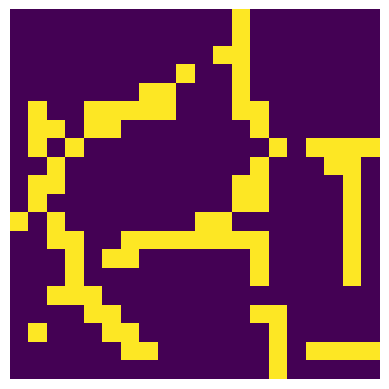

In [12]:
mask2 = np.zeros((H,W)).flatten()
mask2[borders_idxs] = 1
mask2 = mask2.reshape(H,W)

plt.imshow(mask2)
plt.axis('off')
plt.show()

## 5. Locate dead points

The potential death points are arranged in descending order to preserve the sequence of merging partitions in $M$. For each point $x$ in set $B$, if it borders two partitions, these partitions are merged, and $x$ is designated as the $pdeath$ point for the partition with the smallest index. The history of these unions is tracked in vector $C$, which holds the new index in relation to the initial partition index. To enhance the algorithm's efficiency, modifications are restricted to the eight pixels close to the point $x$, rather than applying changes directly to $M$.

In [13]:
pdeath = []
death_idxs = set()
changer = p_idxs.copy()
for x in borders_idxs:
    check = np.unique(changer[new_m[np.array(neighbors(x, H, W, mode=8))] -1])
    if len(check) >= 2:
        check = tuple(check[:2])
        if check not in death_idxs:
            death_idxs.add(check)
            changer[np.where(changer == check[0])[0]] = check[1]
            pdeath.append([check[0] -1, x])
del changer

pdeath = np.array(pdeath)
pdeath = pdeath[np.argsort(pdeath[:,0])][:,1]
pdeath = np.append(pdeath, np.argmin(img))

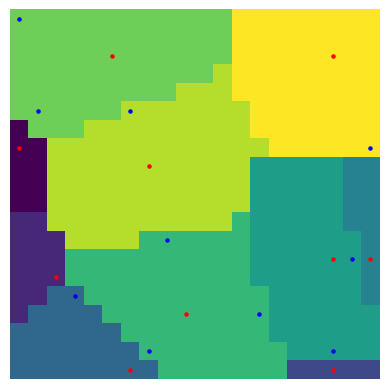

In [14]:
plt.imshow(new_m.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.scatter(pdeath % W, pdeath // W, 5, 'b')
plt.axis('off')
plt.show()

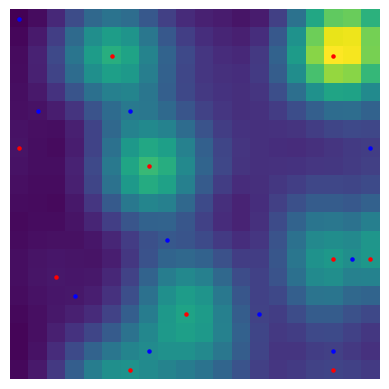

In [15]:
plt.imshow(img.reshape(H,W))
plt.scatter(pbirth % W, pbirth // W, 5, 'r')
plt.scatter(pdeath % W, pdeath // W, 5, 'b')
plt.axis('off')
plt.show()

## 6. Persistence Diagram (DGM)

In the final step, a persistence diagram is created, linking each birth point with the corresponding relative death point within the same partition. The $birth$ and $death$ values for the $pbirth$ and $pdeath$ points are then extracted from the image $I$ and aggregated into a $DGM$ matrix.

In [16]:
dgm = np.stack([img[pbirth],
                img[pdeath]], axis=1)
dgm

array([[0.05277771, 0.04943267],
       [0.0656876 , 0.06317271],
       [0.20702817, 0.18857712],
       [0.51076263, 0.4814553 ],
       [0.5293757 , 0.49486426],
       [0.5322356 , 0.19706908],
       [0.58093137, 0.2759763 ],
       [0.6282401 , 0.40609908],
       [0.6722756 , 0.18125333],
       [1.        , 0.        ]], dtype=float32)

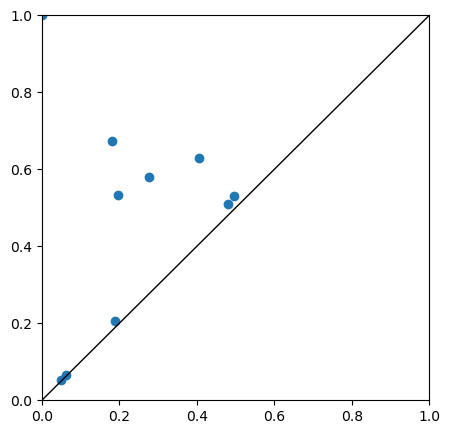

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(dgm[:,1], dgm[:,0])
plt.plot([0, 1], [0, 1], 'k-', lw=1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

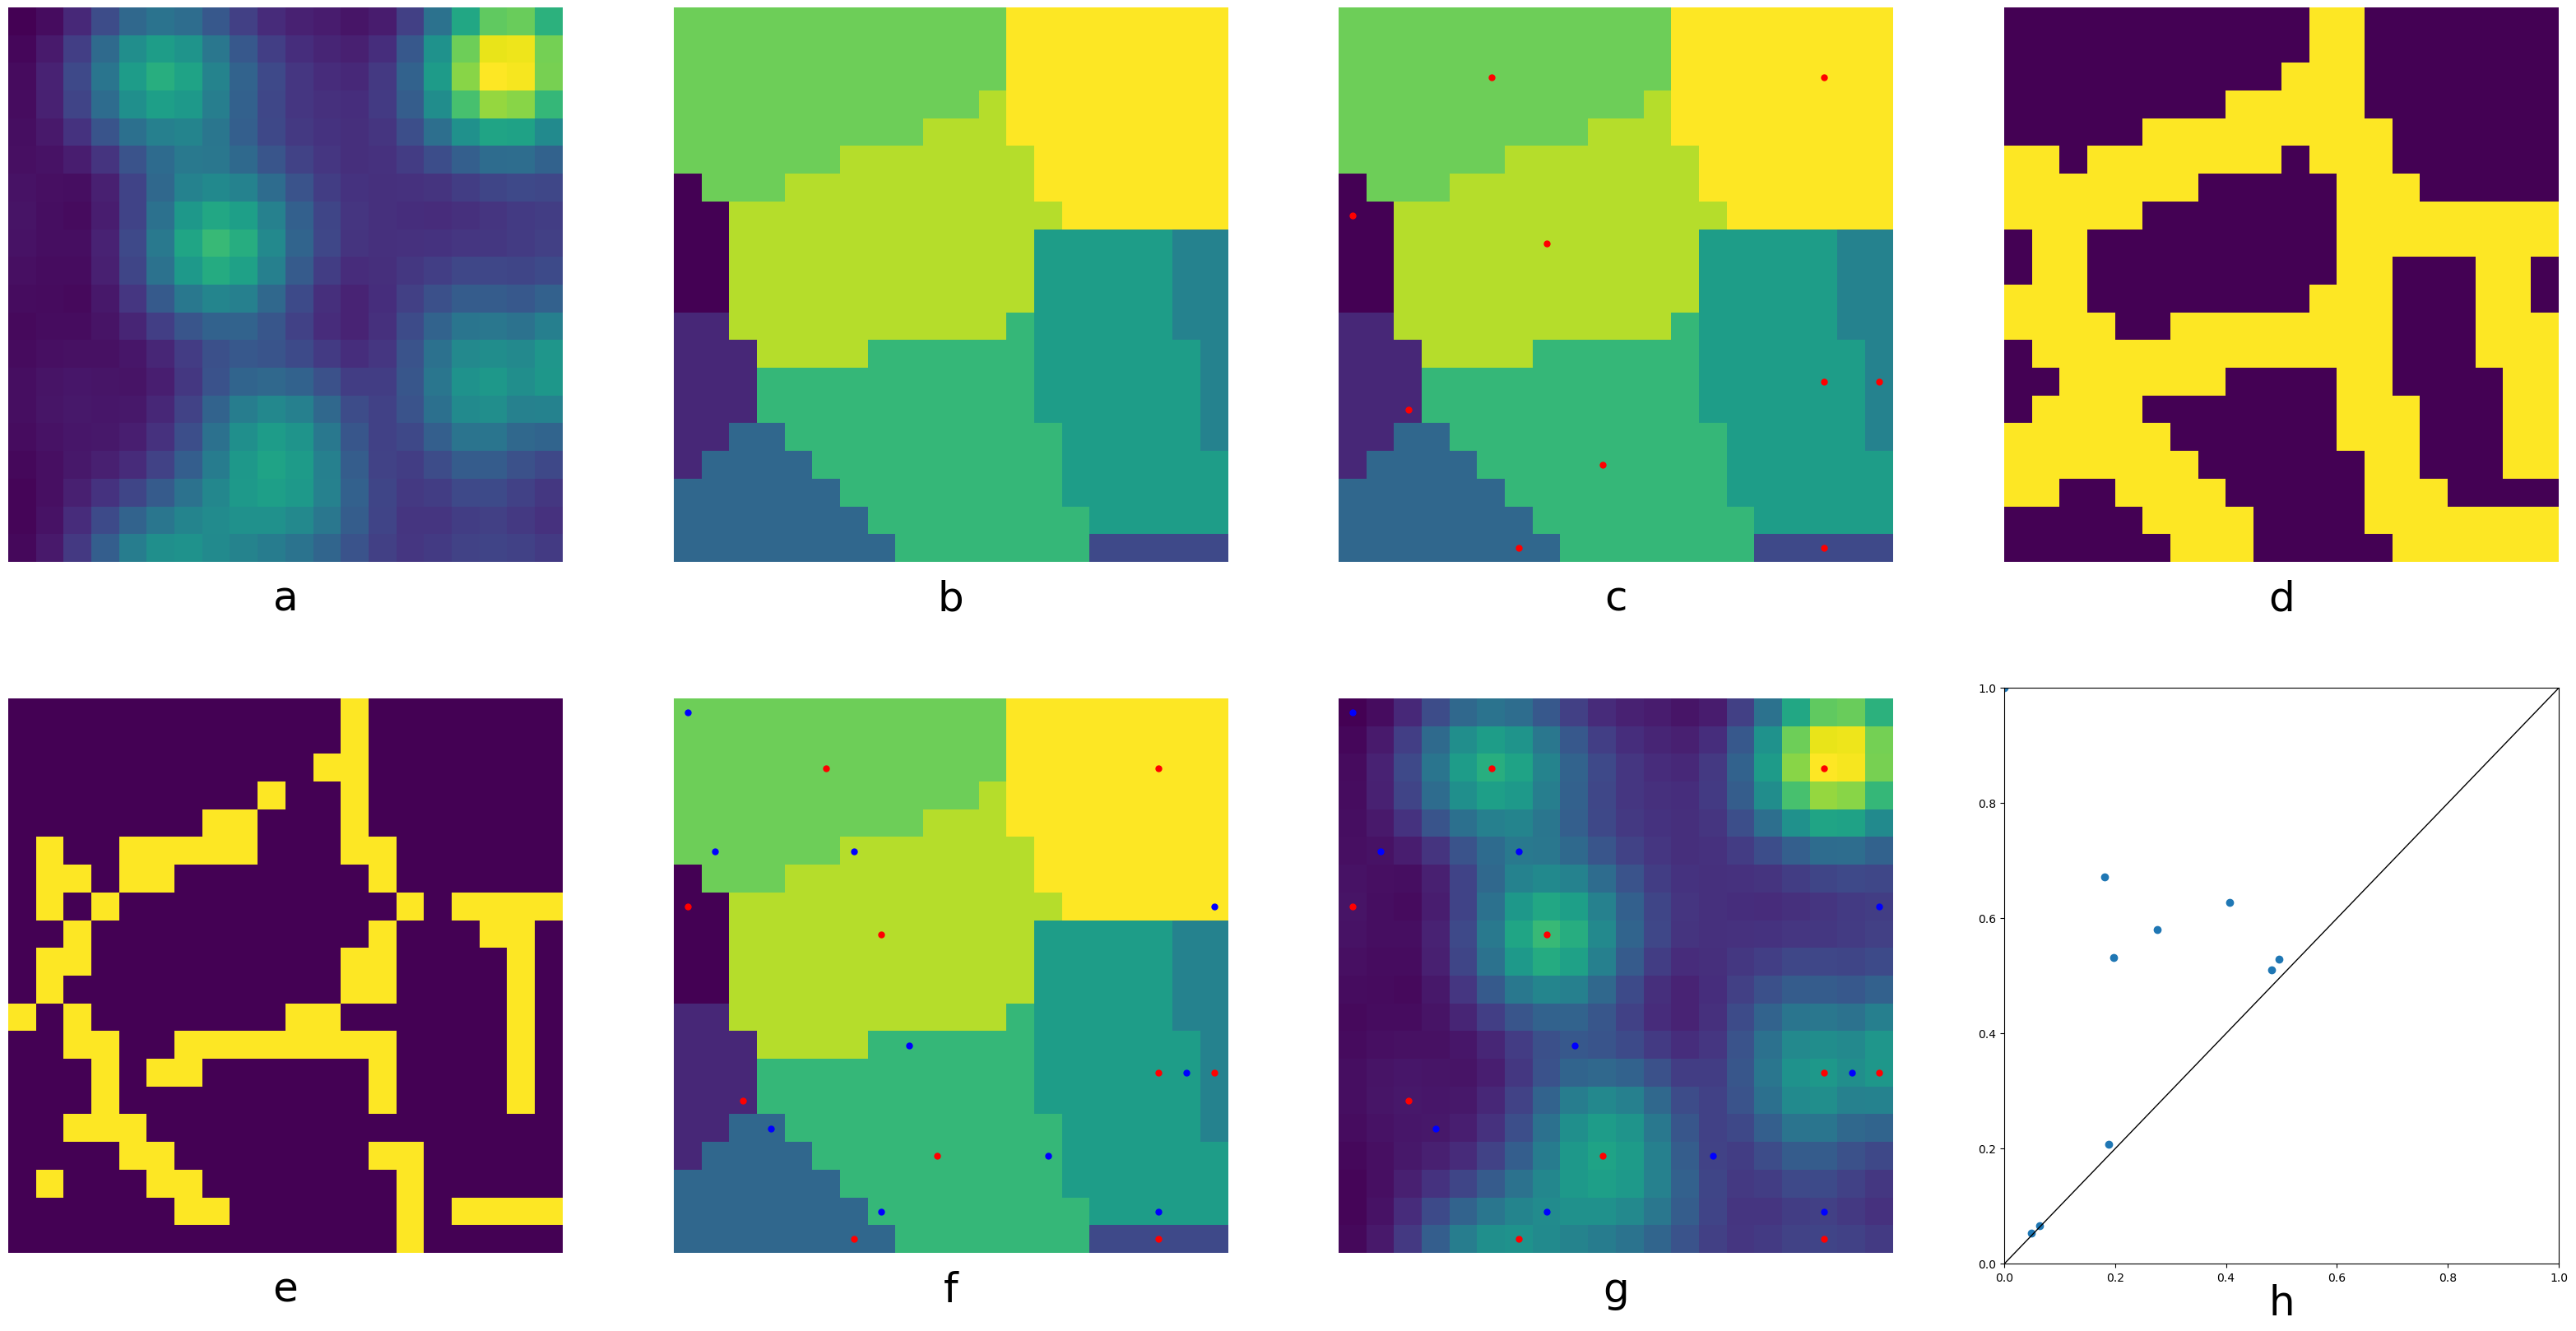

In [18]:
f, arr = plt.subplots(2,4, figsize=(40,20))

arr[0,0].imshow(img.reshape(H,W))
arr[0,0].axis('off')
arr[0,0].set_title('a', y=-0.1, fontsize=36)

arr[0,1].imshow(new_m.reshape(H,W))
arr[0,1].axis('off')
arr[0,1].set_title('b', y=-0.1, fontsize=36)

arr[0,2].imshow(new_m.reshape(H,W))
arr[0,2].scatter(pbirth % W, pbirth // W, 25, 'r')
arr[0,2].axis('off')
arr[0,2].set_title('c', y=-0.1, fontsize=36)

arr[0,3].imshow(mask.reshape(H,W))
arr[0,3].axis('off')
arr[0,3].set_title('d', y=-0.1, fontsize=36)

arr[1,0].imshow(mask2.reshape(H,W))
arr[1,0].axis('off')
arr[1,0].set_title('e', y=-0.1, fontsize=36)

arr[1,1].imshow(new_m.reshape(H,W))
arr[1,1].scatter(pbirth % W, pbirth // W, 25, 'r')
arr[1,1].scatter(pdeath % W, pdeath // W, 25, 'b')
arr[1,1].axis('off')
arr[1,1].set_title('f', y=-0.1, fontsize=36)

arr[1,2].imshow(img.reshape(H,W))
arr[1,2].scatter(pbirth % W, pbirth // W, 25, 'r')
arr[1,2].scatter(pdeath % W, pdeath // W, 25, 'b')
arr[1,2].axis('off')
arr[1,2].set_title('g', y=-0.1, fontsize=36)


arr[1,3].scatter(dgm[:,1], dgm[:,0])
arr[1,3].plot([0, 1], [0, 1], 'k-', lw=1)
arr[1,3].set_xlim([0,1])
arr[1,3].set_ylim([0,1])
arr[1,3].set_title('h', y=-0.1, fontsize=36)

plt.show()